In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pic
from sklearn.model_selection import train_test_split

In [2]:
from joblib import Parallel, delayed
from templates import guessing_entropy

def compute_mean_ranks(per_trace: np.ndarray, key: np.ndarray, bins=10, repeat=500):
    mean_ranks = np.zeros((per_trace.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * per_trace.shape[0] // bins

        #def guess():
        #    subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        #    return guessing_entropy(np.sum(per_trace[subset], axis=0), key)
            
        #ranks = Parallel(n_jobs=-1)(delayed(guess)() for _ in range(REPEAT))

        rank = np.zeros(per_trace.shape[1], dtype=int)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
            rank += guessing_entropy(np.sum(per_trace[subset], axis=0), key)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks

def compute_mean_ranks_keyround(per_trace_keyround: np.ndarray, keyrounds: np.ndarray, bins=10, repeat=100):
    mean_ranks = np.zeros((per_trace_keyround.shape[1], bins), dtype=np.longfloat)
    for bin_ in range(bins):
        print(bin_)
        n_traces = bin_ * per_trace_keyround.shape[0] // bins

        #def guess():
        #    subset = np.random.choice(per_trace.shape[0], size=n_traces, replace=False)
        #    return guessing_entropy(np.sum(per_trace[subset], axis=0), key)
            
        #ranks = Parallel(n_jobs=-1)(delayed(guess)() for _ in range(REPEAT))

        rank = np.zeros(per_trace_keyround.shape[1], dtype=np.float64)
        for _ in range(repeat):
            print(_, end="\r")
            subset = np.random.choice(per_trace_keyround.shape[0], size=n_traces, replace=False)
            rank += np.mean(guessing_entropy(per_trace_keyround[subset], keyrounds[subset]), axis=0)
        mean_ranks[:, bin_] = rank / repeat
    return mean_ranks

In [3]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, round_perms_labels, copy_perms_labels, masks_labels, rws_perms_labels, rws_masks_labels = pic.load(r)

## 45'000 extraction traces (350'000 profiling)

In [ ]:
TRAIN_SIZE = 350_000

In [ ]:
with open("full_data.pic", "rb") as r:
    seeds_total, traces_total, key, output_total, keyshares_total, perms_total = pic.load(r)
with open("per_trace_350000.pic", "rb") as r:
    per_trace_keyround = pic.load(r)

In [ ]:
_, seeds_extraction = train_test_split(seeds_total, train_size=TRAIN_SIZE, random_state=0)
classifications_per_key_nibble = np.sum(per_trace_keyround, axis=0)
mean_ranks = compute_mean_ranks(per_trace_keyround, key)

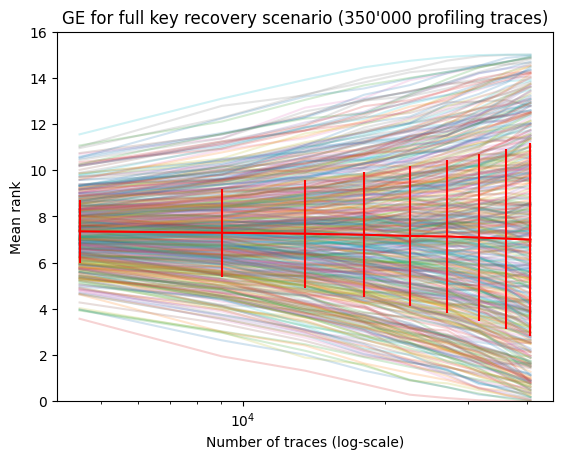

In [116]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:-1], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:-1], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (350'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

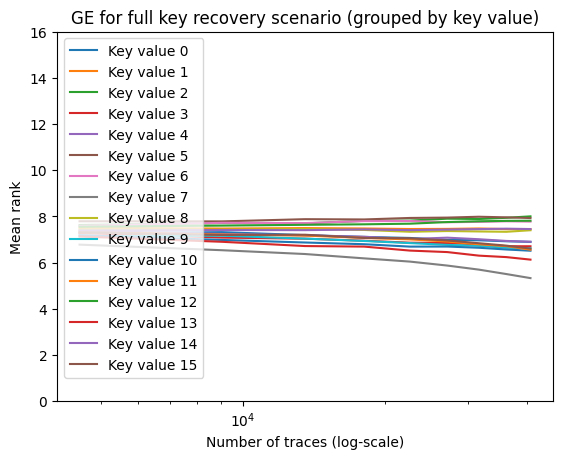

In [34]:
from utils import KEY_ALPHABET
for k in KEY_ALPHABET:
    mean_ranks[key == k]
    plt.plot(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:-1], np.mean(mean_ranks[key == k], axis=0)[1:], label=f"Key value {k}")
plt.xscale("log")
plt.title("GE for full key recovery scenario (grouped by key value)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.legend()
plt.ylim([0, 16])
plt.show()

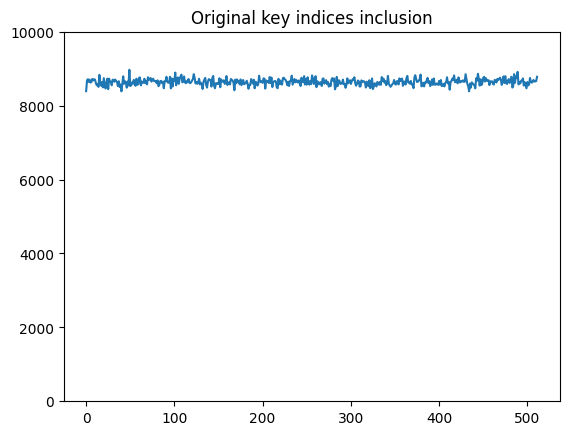

In [88]:
from utils import chacha_random_b4
plt.plot(*np.unique(np.array([chacha_random_b4(seed)[0][:98] for seed in seeds_extraction]), return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 10_000])
plt.title("Original key indices inclusion")
plt.show()

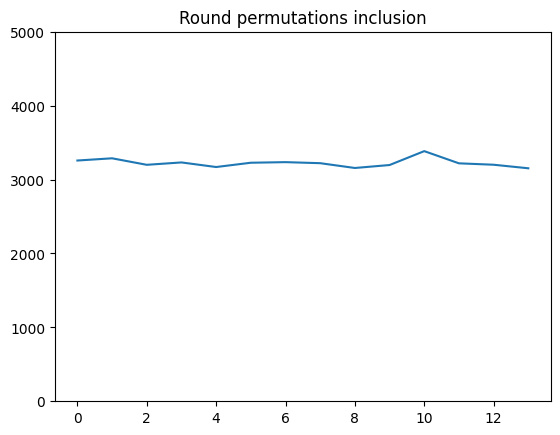

In [97]:
plt.plot(*np.unique(train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 5_000])
plt.title("Round permutations inclusion")
plt.show()

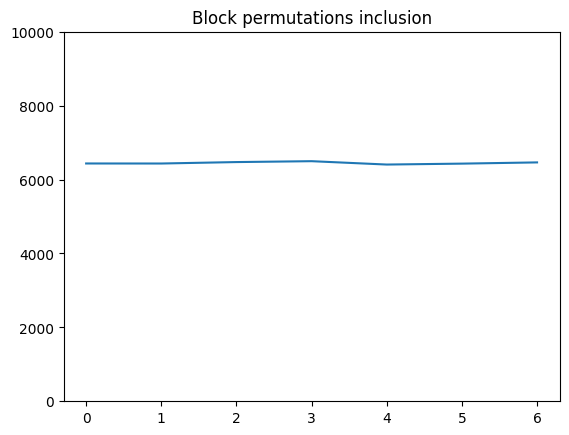

In [98]:
plt.plot(*np.unique(train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 2], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 10_000])
plt.title("Block permutations inclusion")
plt.show()

In [104]:
from templates import get_masks_labels
masks_labels = get_masks_labels(seeds_extraction, key, train_test_split(keyshares_total, train_size=TRAIN_SIZE, random_state=0)[1], train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 1], train_test_split(perms_total, train_size=TRAIN_SIZE, random_state=0)[1][:, 2:3:1])

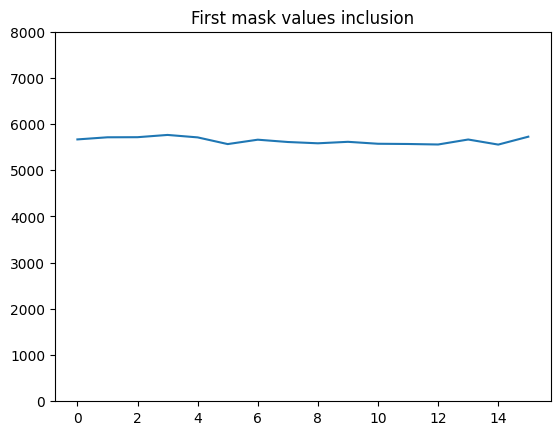

In [111]:
plt.plot(*np.unique(masks_labels[:, 0], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8000])
plt.title("First mask values inclusion")
plt.show()

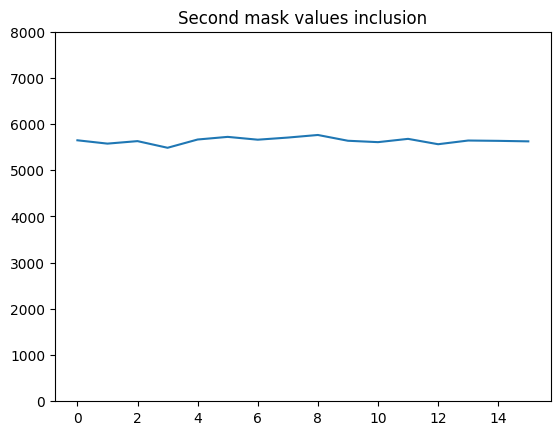

In [109]:
plt.plot(*np.unique(masks_labels[:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8000])
plt.title("Second mask values inclusion")
plt.show()

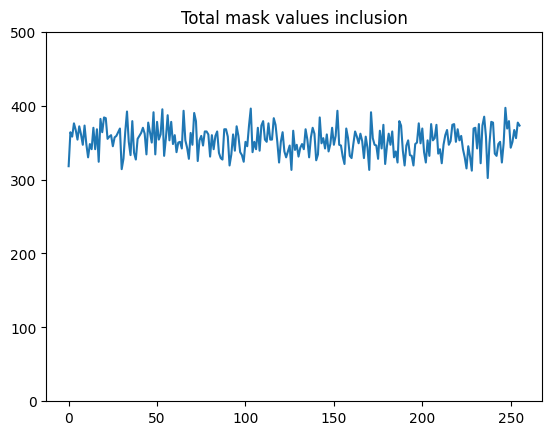

In [112]:
plt.plot(*np.unique(16 * masks_labels[:, 0] + masks_labels[:, 1], return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 500])
plt.title("Total mask values inclusion")
plt.show()

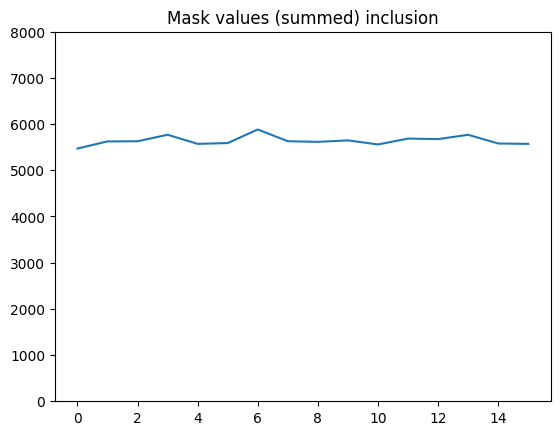

In [114]:
plt.plot(*np.unique((masks_labels[:, 0] + masks_labels[:, 1]) % 16, return_counts=True))
#plt.xlim([305, 315])
plt.ylim([0, 8_000])
plt.title("Mask values (summed) inclusion")
plt.show()

## 100'000 extraction traces (295'000 profiling)

In [4]:
TEST_SIZE = 100_000

In [5]:
with open("y_extraction_epoch_35.pic", "rb") as r:
    y_predicted = pic.load(r)

In [7]:
from templates import classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
masks_probas = np.stack(y_predicted[2:], axis=1)[:, np.newaxis, ...]

per_trace = classifications_per_trace("per_trace_300000.pic", seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, masks_rws_keep_only=np.empty((98, 0)), parallel=False)
recovered_key = reconstruct_key(per_trace)

KeyboardInterrupt: 

In [9]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key)
with open("mean_ranks_300000.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


In [4]:
mean_ranks = np.concatenate((mean_ranks, guessing_entropy(np.sum(per_trace, axis=0), key)[:, np.newaxis]), axis=1)

NameError: name 'mean_ranks' is not defined

In [32]:
mean_ranks = mean_ranks[:, :-1]

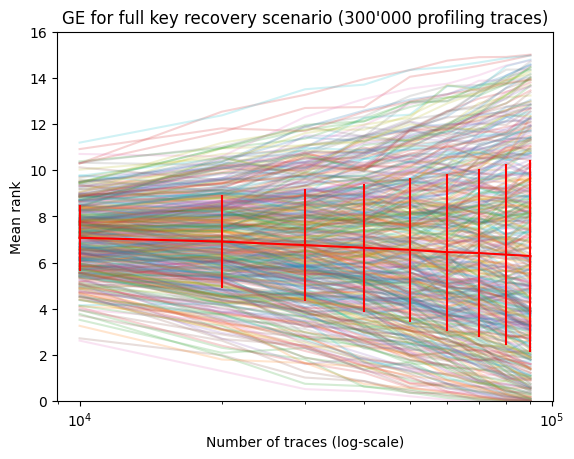

In [42]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // BINS)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [36]:
np.mean(mean_ranks, axis=0)[1:]

array([7.07128906, 6.90603516, 6.75365234, 6.63802734, 6.55037109,
       6.44861328, 6.41083984, 6.34001953, 6.28273438], dtype=float64)

In [6]:
with open("per_trace_300000.pic", "rb") as r:
    per_trace = pic.load(r)

In [13]:
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)


In [14]:
from utils import chacha_random_b4
per_trace_keyround = np.zeros((TEST_SIZE, 98, 16))
for i, (seed, preds) in enumerate(zip(seeds_extraction, per_trace)):
    ind, _ = chacha_random_b4(seed)
    per_trace_keyround[i] = preds[ind[:98]]

In [15]:
per_trace_keyround.shape

(100000, 98, 16)

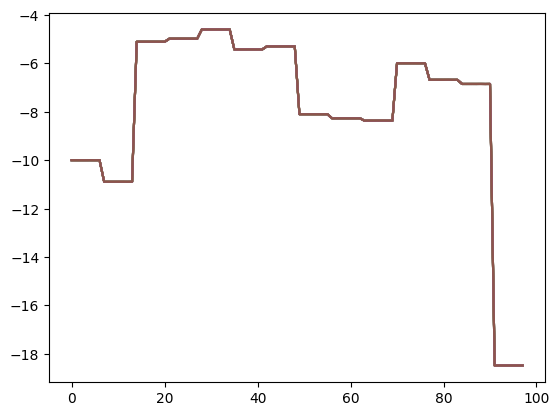

In [16]:
for k in range(16):
    plt.plot(np.mean(per_trace_keyround[:, :, k], axis=0))

In [39]:
train_test_split(round_perms_labels, test_size=TEST_SIZE, random_state=0)[1].shape

(100000,)

In [43]:
np.argmax(y_predicted[1], axis=1).shape

(100000,)

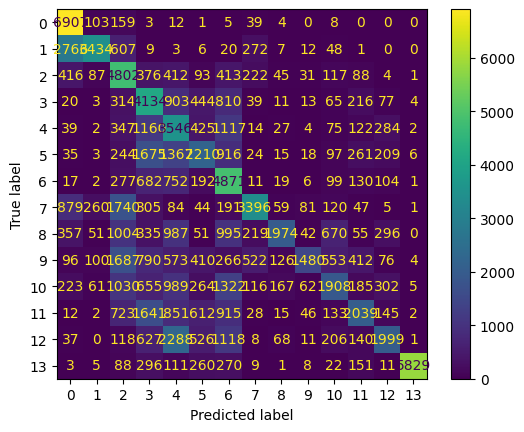

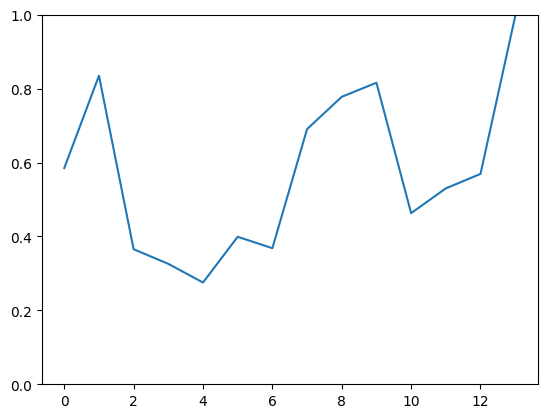

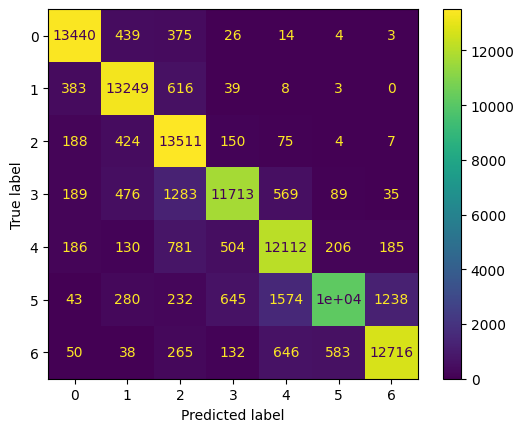

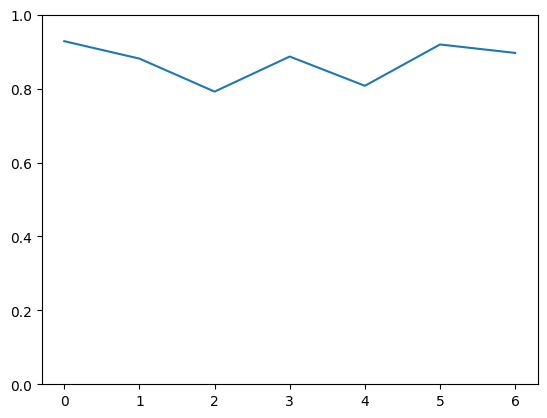

In [54]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score
ConfusionMatrixDisplay(confusion_matrix(train_test_split(round_perms_labels, test_size=TEST_SIZE, random_state=0)[1], np.argmax(y_predicted[0], axis=1))).plot()
plt.show()
plt.plot(precision_score(train_test_split(round_perms_labels, test_size=TEST_SIZE, random_state=0)[1], np.argmax(y_predicted[0], axis=1), average=None))
plt.ylim([0, 1])
plt.show()
ConfusionMatrixDisplay(confusion_matrix(train_test_split(copy_perms_labels[0], test_size=TEST_SIZE, random_state=0)[1], np.argmax(y_predicted[1], axis=1))).plot()
plt.show()
plt.plot(precision_score(train_test_split(copy_perms_labels[0], test_size=TEST_SIZE, random_state=0)[1], np.argmax(y_predicted[1], axis=1), average=None))
plt.ylim([0, 1])
plt.show()

In [18]:
from utils import chacha_random_b4
y_profiling_keyround = np.zeros((TEST_SIZE, 98))
for i, seed in enumerate(seeds_extraction):
    ind, whi = chacha_random_b4(seed)
    y_profiling_keyround[i] = (key[ind[:98]] + whi) % 16

In [27]:
mean_ranks_keyround = compute_mean_ranks_keyround(per_trace_keyround, y_profiling_keyround)

0
1
2
3
4
5
6
7
8
9


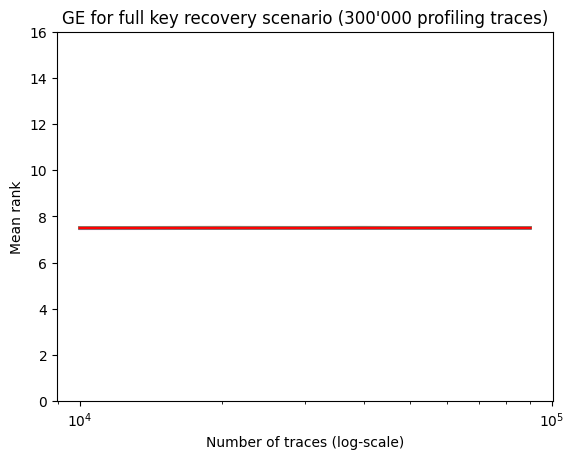

In [31]:
for n, nibble_ranks in enumerate(mean_ranks_keyround):
    plt.plot(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // BINS)[1:], np.mean(mean_ranks_keyround, axis=0)[1:], np.std(mean_ranks_keyround, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [33]:
np.mean(mean_ranks_keyround, axis=0)[1:]

array([7.4956699 , 7.49880434, 7.49770218, 7.49859671, 7.49814843,
       7.49795276, 7.49773243, 7.49814593, 7.49806116], dtype=float64)

## 100'000 extraction traces (295'000 profiling), doing like the paper

In [4]:
TEST_SIZE = 100_000

In [5]:
with open("y_extraction_epoch_35.pic", "rb") as r:
    y_predicted = pic.load(r)

In [6]:
from templates import classifications_per_trace, reconstruct_key
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
round_perm_probas = y_predicted[0]
copy_perm_probas = y_predicted[1][:, np.newaxis, :]
masks_probas = np.stack(y_predicted[2:], axis=1)[:, np.newaxis, ...]

#per_trace = classifications_per_trace("per_trace_300000_only_best_round_perms.pic", seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, round_keep_only=np.array([1, 8, 9, 13]), masks_rws_keep_only=np.empty((98, 0)), parallel=True)
per_trace = classifications_per_trace("per_trace_300000_like_paper_only_round_13.pic", seeds_extraction, np.zeros((seeds_extraction.shape[0], 98)), np.zeros((seeds_extraction.shape[0], 98, 256)), round_perm_probas, copy_perm_probas, masks_probas, parallel=True)
recovered_key = reconstruct_key(per_trace)

In [7]:
np.count_nonzero(recovered_key == key) / 512

0.08984375

In [8]:
np.sum(per_trace, axis=0)[0]

array([-3088.72301557, -3087.34104912, -3086.12716124, -3085.04034909,
       -3084.64822381, -3087.21848598, -3086.9791491 , -3087.33535848,
       -3087.76299156, -3087.41921674, -3086.68567059, -3085.94695328,
       -3085.89998885, -3086.75275213, -3086.40091363, -3085.15925162])

In [10]:
classifications_per_key_nibble = np.sum(per_trace, axis=0)
mean_ranks = compute_mean_ranks(per_trace, key, repeat=100)
with open("mean_ranks_300000_only_best_round_perms.pic", "wb") as w:
    pic.dump(mean_ranks, w)

0
19
29
39
49
59
69
79
89
99


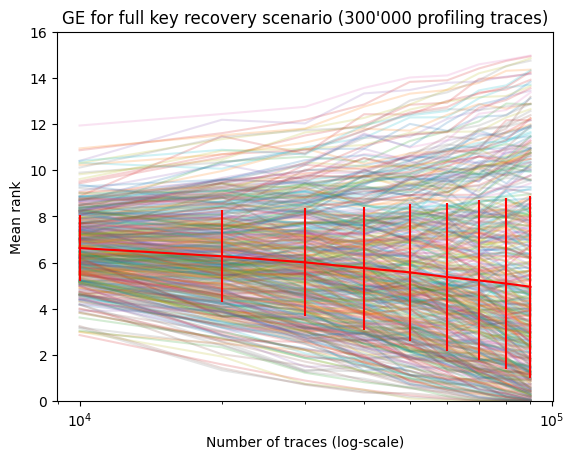

In [13]:
for n, nibble_ranks in enumerate(mean_ranks):
    plt.plot(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace.shape[0], per_trace.shape[0] // 10)[1:], np.mean(mean_ranks, axis=0)[1:], np.std(mean_ranks, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for full key recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [14]:
from utils import chacha_random_b4
per_trace_keyround = np.zeros((TEST_SIZE, 98, 16))
for i, (seed, preds) in enumerate(zip(seeds_extraction, per_trace)):
    ind, _ = chacha_random_b4(seed)
    per_trace_keyround[i] = preds[ind[:98]]

In [15]:
per_trace_keyround.shape

(100000, 98, 16)

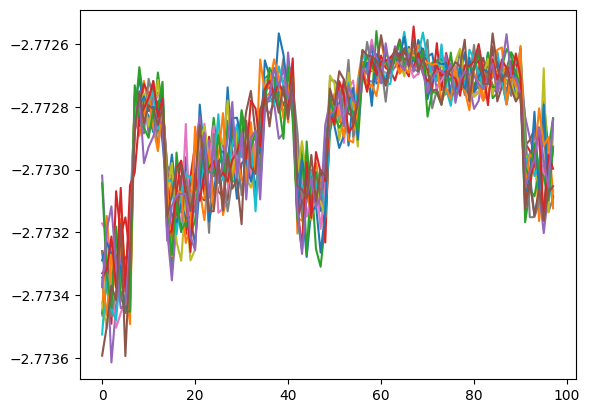

In [16]:
for k in range(16):
    plt.plot(np.mean(per_trace_keyround[:, :, k], axis=0))

In [9]:
with open("per_trace_300000_only_best_round_perms.pic", "rb") as r:
    per_trace = pic.load(r)

In [24]:
from utils import chacha_random_b4
_, seeds_extraction = train_test_split(seeds_total, test_size=TEST_SIZE, random_state=0)
per_trace_keyround = np.zeros((TEST_SIZE, 98, 16))
for i, (seed, preds) in enumerate(zip(seeds_extraction, per_trace)):
    ind, _ = chacha_random_b4(seed)
    per_trace_keyround[i] = preds[ind[:98]]
    
y_profiling_keyround = np.zeros((TEST_SIZE, 98))
for i, seed in enumerate(seeds_extraction):
    ind, whi = chacha_random_b4(seed)
    y_profiling_keyround[i] = key[ind[:98]]

In [25]:
mean_ranks_keyround = compute_mean_ranks_keyround(per_trace_keyround, y_profiling_keyround, repeat=10)

0
1


c:\Users\Kudelski\Documents\Pierugo-PDM-2024\protected_side_channel_attack\.venv\Lib\site-packages\numpy\core\fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
c:\Users\Kudelski\Documents\Pierugo-PDM-2024\protected_side_channel_attack\.venv\Lib\site-packages\numpy\core\_methods.py:121: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(


2
3
4
5
6
7
8
9


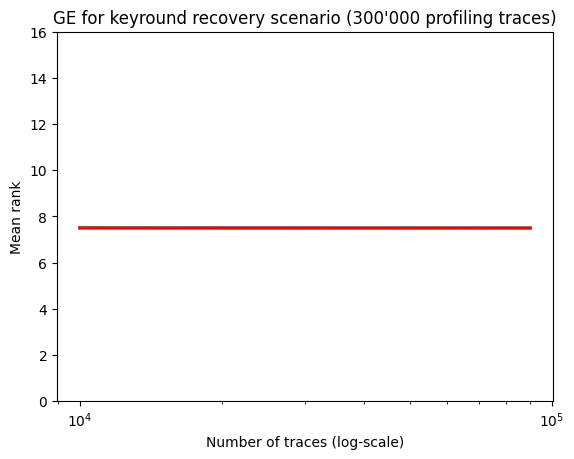

In [30]:
for n, nibble_ranks in enumerate(mean_ranks_keyround):
    plt.plot(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // 10)[1:], nibble_ranks[1:], label=f"Key nibble {n}", alpha=0.2)
plt.errorbar(range(0, per_trace_keyround.shape[0], per_trace_keyround.shape[0] // 10)[1:], np.mean(mean_ranks_keyround, axis=0)[1:], np.std(mean_ranks_keyround, axis=0)[1:], color="red")
plt.xscale("log")
plt.title("GE for keyround recovery scenario (300'000 profiling traces)")
plt.xlabel("Number of traces (log-scale)")
plt.ylabel("Mean rank")
plt.ylim([0, 16])
#plt.legend()
plt.show()

In [27]:
np.mean(mean_ranks_keyround, axis=0)[1:]

array([7.4936799 , 7.49286092, 7.49234544, 7.49272594, 7.49277829,
       7.49249262, 7.49290726, 7.49226607, 7.49239533], dtype=float64)